In [5]:
%run A_FunctionDefinitions.ipynb ;

In [2]:
gauge=5393500 #8202700 
scaled=1 #1: scales to mean flow
         #0: leaves flows in ft^3/s"""

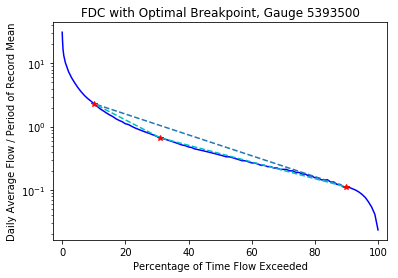

In [3]:
upslope_value=90
downslope_value=10

data=loadflow(gauge)

# FLOW DURATION CURVE
#removing partial years/nulls 
numdays=329 #minimum number of days to be accepted
data=data[data[4] != -999.0] #remove nulls
yr1=min(data[1].values)
yrEnd=max(data[1].values)
for year in range(yr1,yrEnd+1):
    if np.sum(data[1]==year)<numdays:
        data=data[data[1] != year]

flows=data[4].values

#RUN DRY? 
if np.min(flows) == 0:
    Dry=1
    PctFlow=np.sum(flows!=0)/np.size(flows)
    flows=data[data[4]!=0][4].values
else:
    Dry=0
    PctFlow=100

P=100*np.append(np.linspace(0,1,100,endpoint=False),[.995,.9975,.999,.9999])
threshold=np.percentile(flows,P)
if scaled==1: meanflow = np.mean(flows); modthresh=threshold/meanflow
if scaled==0: modthresh=threshold

fdc=pd.DataFrame({'Flow':threshold,'Scaled Flow':modthresh,'Percent Exceed':100-P})
pct=fdc['Percent Exceed'].values
flw=fdc['Scaled Flow'].values 

#ONE LINE PREDICTOR
upslope=flw[pct==upslope_value]
downslope=flw[pct==downslope_value]

m=(np.log(upslope)-np.log(downslope))/(downslope_value-upslope_value)
def slopeprediction(x):
    return np.exp(np.log(upslope)-m*(x-upslope_value))

pct_subset=pct[pct>downslope_value][pct[pct>downslope_value]<upslope_value]
predictions_oneline=slopeprediction(pct_subset)
flw_subset=flw[pct>downslope_value][pct[pct>downslope_value]<upslope_value]

#BEST BREAKPOINT DETERMINATION
breakpoint_tests=pct_subset 
N_tests=np.size(breakpoint_tests)

def slopeprediction_2(x):
    if x >= breakpoint:
        return np.exp(np.log(upslope)-m_A*(x-upslope_value))
    else:
        return np.exp(np.log(breakpoint_flw)-m_B*(x-breakpoint))

out=np.zeros(shape=(N_tests,5))
for index in range(0,N_tests):
    breakpoint=breakpoint_tests[index]
    breakpoint_flw=flw[pct==breakpoint]
    m_A=(np.log(upslope)-np.log(breakpoint_flw))/(breakpoint-upslope_value)
    m_B=(np.log(breakpoint_flw)-np.log(downslope))/(downslope_value-breakpoint)

    predictions_2=np.zeros(shape=np.shape(flw_subset))
    for i in range (0,np.size(flw_subset)):
        predictions_2[i]=slopeprediction_2(pct_subset[i])
    log_diff_2=np.log(predictions_2)-np.log(flw_subset)
    abs_log_diff_2=np.abs(log_diff_2)
    error=np.mean(abs_log_diff_2)
    error_b=np.mean(log_diff_2)

    out[index,0]=breakpoint
    out[index,1]=error
    out[index,2]=m_A
    out[index,3]=m_B
    out[index,4]=error_b
out=pd.DataFrame(out,columns=['pct','err','m_A','m_B','err_b'])
true_2line=out[out.err==np.min(out.err)]

true_breakpoint=true_2line.pct.values
meanabsdiff_2line=true_2line.err.values
m_A=true_2line.m_A.values
m_B=true_2line.m_B.values
breakpoint_flw=flw[pct==true_breakpoint]

#PREDICTED VALUES 2 LINES
def slopeprediction_2line(x):
    if x >= true_breakpoint:
        return np.exp(np.log(upslope)-m_A*(x-upslope_value))
    else:
        return np.exp(np.log(breakpoint_flw)-m_B*(x-true_breakpoint))
L=np.size(pct_subset)
predictions_2line=np.zeros(shape=(L,1))
for i in range (0,L):
    predictions_2line[i]=slopeprediction_2line(pct_subset[i])

#PLOTTING
if Dry == 1:   #rescaling the plot if the catchment runs dry
    true_breakpoint=PctFlow*true_breakpoint
    pct=PctFlow*pct
    pct_subset=PctFlow*pct_subset
    upslope_value=PctFlow*upslope_value
    downslope_value=PctFlow*downslope_value

fig=plt.figure()
plt.semilogy(pct,flw,'b-')
plt.semilogy(pct_subset,predictions_oneline,'--')
plt.semilogy(pct_subset,predictions_2line,'c--')
plt.semilogy(upslope_value,upslope,'r*',downslope_value,downslope,'r*',true_breakpoint,breakpoint_flw,'r*')
if scaled==1: plt.ylabel('Daily Average Flow / Period of Record Mean')
if scaled==0: plt.ylabel('Daily Average Flow (ft$^3$/s)')
plt.xlabel('Percentage of Time Flow Exceeded')
plt.title('FDC with Optimal Breakpoint, Gauge '+str(gauge))
axes = plt.gca()
axes.set_xlim([-3,103])
plt.show()

#ERROR VALUES
log_diff_oneline=np.log(predictions_oneline)-np.log(flw_subset)
meandiff_oneline=np.mean(log_diff_oneline)

err_1=meandiff_oneline
err_2=true_2line.err_b.values[0]
ratio=err_1/err_2

In [4]:
print('Breakpoint: '+str(true_breakpoint))
print('Percent Flow: '+str(PctFlow))
print('Error 1 Line: '+str(err_1))
print('Error 2 Line: '+str(err_2))

Breakpoint: [31.]
Percent Flow: 100
Error 1 Line: 0.252962283789161
Error 2 Line: 0.026877038994954385
